<center>
    <h2>Banking Credit Risk Analytics</h2>
</center>

#### Import Packages 


In [109]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

#### Data Availability

In [110]:
data=pd.read_csv('bankloans.csv')
data.head()

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0   41   3      17       12     176      9.3  11.359392  5.008608      1.0
1   27   1      10        6      31     17.3   1.362202  4.000798      0.0
2   40   1      15       14      55      5.5   0.856075  2.168925      0.0
3   41   1      15       14     120      2.9   2.658720  0.821280      0.0
4   24   2       2        0      28     17.3   1.787436  3.056564      1.0

#### Exploratory Data Analysis

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [112]:
data.describe()

age          ed      employ     address      income     debtinc  \
count  850.000000  850.000000  850.000000  850.000000  850.000000  850.000000   
mean    35.029412    1.710588    8.565882    8.371765   46.675294   10.171647   
std      8.041432    0.927784    6.777884    6.895016   38.543054    6.719441   
min     20.000000    1.000000    0.000000    0.000000   13.000000    0.100000   
25%     29.000000    1.000000    3.000000    3.000000   24.000000    5.100000   
50%     34.000000    1.000000    7.000000    7.000000   35.000000    8.700000   
75%     41.000000    2.000000   13.000000   12.000000   55.750000   13.800000   
max     56.000000    5.000000   33.000000   34.000000  446.000000   41.300000   

         creddebt     othdebt     default  
count  850.000000  850.000000  700.000000  
mean     1.576805    3.078789    0.261429  
std      2.125840    3.398803    0.439727  
min      0.011696    0.045584    0.000000  
25%      0.382176    1.045942    0.000000  
50%      0.885091    2.003243    0.000000  
75%      1.898440    3.903001    1.000000  
max     20.561310   35.197500    1.000000

In [113]:
# udf to analyze continuous data 
def continuous_summ(x):
    n_total=x.shape[0]
    
    n_miss=x.isna().sum()
    perc_miss=n_miss*100/n_total
    
    q1=x.quantile(0.25)
    q3=x.quantile(0.75)
    iqr=q3-q1
    uc=q3+1.5*iqr
    lc=q1-1.5*iqr
    n_outliers=((x>uc)|(x<lc)).sum()
    perc_outliers=n_outliers*100/n_total
    
    return pd.Series([x.dtypes,n_total,x.count(),x.nunique(),n_miss,perc_miss,n_outliers,perc_outliers,lc,x.min(),uc,x.max()],
            index=['dtype','total_observations','n','cardinality','null_count','perc_null','total_outliers','perc_outliers','lc','min','uc','max'])

In [114]:
data.apply(continuous_summ)

age        ed    employ   address    income   debtinc  \
dtype               int64     int64     int64     int64     int64   float64   
total_observations    850       850       850       850       850       850   
n                     850       850       850       850       850       850   
cardinality            37         5        33        32       129       245   
null_count              0         0         0         0         0         0   
perc_null             0.0       0.0       0.0       0.0       0.0       0.0   
total_outliers          0        54        10        19        53        21   
perc_outliers         0.0  6.352941  1.176471  2.235294  6.235294  2.470588   
lc                   11.0      -0.5     -12.0     -10.5   -23.625     -7.95   
min                    20         1         0         0        13       0.1   
uc                   59.0       3.5      28.0      25.5   103.375     26.85   
max                    56         5        33        34       446      41.3   

                    creddebt   othdebt    default  
dtype                float64   float64    float64  
total_observations       850       850        850  
n                        850       850        700  
cardinality              842       848          2  
null_count                 0         0        150  
perc_null                0.0       0.0  17.647059  
total_outliers            69        61          0  
perc_outliers       8.117647  7.176471        0.0  
lc                 -1.892221 -3.239646       -1.5  
min                 0.011696  0.045584        0.0  
uc                  4.172837  8.188589        2.5  
max                 20.56131   35.1975        1.0

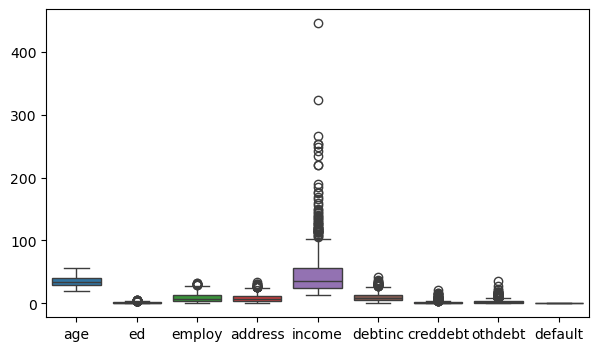

In [115]:
plt.figure(figsize=(7,4))       
sns.boxplot(data.select_dtypes(include='number'))  #or data.select_dtypes(include='number').boxplot(vert=False)
plt.show()

# to check the outliers in each individual column code is here:

#for col in people_with_info.select_dtypes(include='number').columns:
#    sns.boxplot(x=people_with_info[col])
#    plt.show()

##### ***if there are null values present in out data then outlier treatment method will not work so first clean the outliers and always remenber that the data types of all columns must be numeric for  outlier treatment to apply***

##### Segregating the bankloan customers such that we have new and existing customers separate:

In [116]:
people_with_info = data[data['default'].isnull()==False]
people_without_info = data[data['default'].isnull()==True]

In [117]:
people_with_info.shape,people_without_info.shape

((700, 9), (150, 9))

#### Outlier Handling

In [118]:
people_with_info=people_with_info.apply(lambda x: x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99)))
people_with_info.apply(continuous_summ)

age        ed    employ  address    income  debtinc  \
dtype               float64     int64   float64  float64   float64  float64   
total_observations      700       700       700      700       700      700   
n                       700       700       700      700       700      700   
cardinality              34         4        29       28       107      221   
null_count                0         0         0        0         0        0   
perc_null               0.0       0.0       0.0      0.0       0.0      0.0   
total_outliers            0        43        10       14        40       14   
perc_outliers           0.0  6.142857  1.428571      2.0  5.714286      2.0   
lc                     12.5      -0.5     -10.5    -10.5     -22.5  -8.6875   
min                    21.0         1       0.0      0.0      15.0      0.9   
uc                     56.5       3.5      25.5     25.5     101.5  27.8125   
max                   53.01         4     27.01    26.01     190.3   30.701   

                    creddebt    othdebt  default  
dtype                float64    float64  float64  
total_observations       700        700      700  
n                        700        700      700  
cardinality              683        687        2  
null_count                 0          0        0  
perc_null                0.0        0.0      0.0  
total_outliers            55         48        0  
perc_outliers       7.857143   6.857143      0.0  
lc                 -1.930284  -3.274152     -1.5  
min                 0.030209   0.160936      0.0  
uc                  4.201299   8.241395      2.5  
max                 9.891428  17.184744      1.0

###### another way of EDA using ydata_profiling


In [119]:
profile=ProfileReport(data,title="Bankloan Customers info")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [120]:
x_vars=[colname for colname in people_with_info.columns if colname !='default']

x=people_with_info[x_vars]                # or people_with_info.iloc[:,:-1]
y=people_with_info['default'].astype('int64')

#### Split the data into Train and Validation set

In [121]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.33,random_state=42,stratify=y)

In [122]:
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((469, 8), (231, 8), (469,), (231,))

#### Feature Selection

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
rfe=RFE(estimator=RandomForestClassifier(),n_features_to_select=5)
rfe.fit(x_train,y_train)
rfe

RFE(estimator=RandomForestClassifier(), n_features_to_select=5)

In [125]:
print("Selected_features",x_train.columns[rfe.support_])
print("features_ranking",rfe.ranking_)

Selected_features Index(['employ', 'income', 'debtinc', 'creddebt', 'othdebt'], dtype='object')
features_ranking [2 4 1 3 1 1 1 1]


##### or

In [126]:
selected_features= x_train.columns[rfe.get_support()]
selected_features

Index(['employ', 'income', 'debtinc', 'creddebt', 'othdebt'], dtype='object')

#### Model Building (with best parameter using Hyperparameter tunning )

In [127]:
from sklearn.model_selection import GridSearchCV

In [128]:
params={
    "n_estimators":[10,20,40,80,100],
    "max_depth":[2,3,5]
}
rf_estimator=RandomForestClassifier(n_jobs=-1,oob_score=True,random_state=1024)

In [129]:
cv_rf=GridSearchCV(rf_estimator,params,cv=5)
cv_rf.fit(x_train,y_train)
cv_rf

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=1024),
             param_grid={'max_depth': [2, 3, 5],
                         'n_estimators': [10, 20, 40, 80, 100]})

In [130]:
cv_rf.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=80, n_jobs=-1, oob_score=True,
                       random_state=1024)

In [131]:
best_model =cv_rf.best_estimator_
print("OOB Score of Best Estimator:", best_model.oob_score_)


OOB Score of Best Estimator: 0.7697228144989339


#### Model Evaluations 

In [132]:
# Evaluate model's performance on train set 

print(classification_report(y_train,cv_rf.predict(x_train)))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       346
           1       0.96      0.55      0.70       123

    accuracy                           0.88       469
   macro avg       0.91      0.77      0.81       469
weighted avg       0.89      0.88      0.86       469



In [133]:
#Evaluate model's performance on test set 

print(classification_report(y_val,cv_rf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       171
           1       0.70      0.50      0.58        60

    accuracy                           0.81       231
   macro avg       0.77      0.71      0.73       231
weighted avg       0.80      0.81      0.80       231



#### To save the model for future data prediction 

In [134]:
import pickle

In [135]:
with open('RF_Credit_risk_model.pkl','wb') as file:
    pickle.dump(best_model,file)
                 
                # or 

#filename="RF_Credit_risk_model.pkl"
#pickle.dump(best_model,open(filename, 'wb'))


#### Load the model 

In [136]:
with open('RF_Credit_risk_model.pkl','rb') as file:
    retrived_model = pickle.load(file)

#### Model Predictions on Future Data

In [145]:
missing_data_pred=retrived_model.predict(people_without_info.iloc[:,:-1])
missing_data_pred

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [153]:
missing_defaults=pd.Series(missing_data_pred,index=people_without_info.index)
missing_defaults

700    0
701    0
702    1
703    0
704    0
      ..
845    0
846    0
847    0
848    0
849    0
Length: 150, dtype: int64

In [155]:
people_without_info['default'].fillna(missing_defaults,inplace=True)

In [158]:
people_without_info['default'].value_counts()

default
0.0    133
1.0     17
Name: count, dtype: int64